# Optimizing to reproduce the Haslam map

Here we'll briefly introduce how to optimize a grid $\mathbf{B}$ model to produce a [Haslam 408 MHz map](https://lambda.gsfc.nasa.gov/product/foreground/fg_2014_haslam_408_get.html).

In [1]:
#%env XLA_PYTHON_CLIENT_PREALLOCATE=false
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform


env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


In [2]:
import os
import sys
import jax,blackjax
jax.config.update("jax_enable_x64", True)
#sys.path.append('../synax/')

import synax,importlib
import jax.numpy as jnp
import interpax
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import scipy.constants as const

## read observations

Remember replace the filename with your actual directory!

And we will spatial average it to get a NSIDE = 64 map.

(49152,)


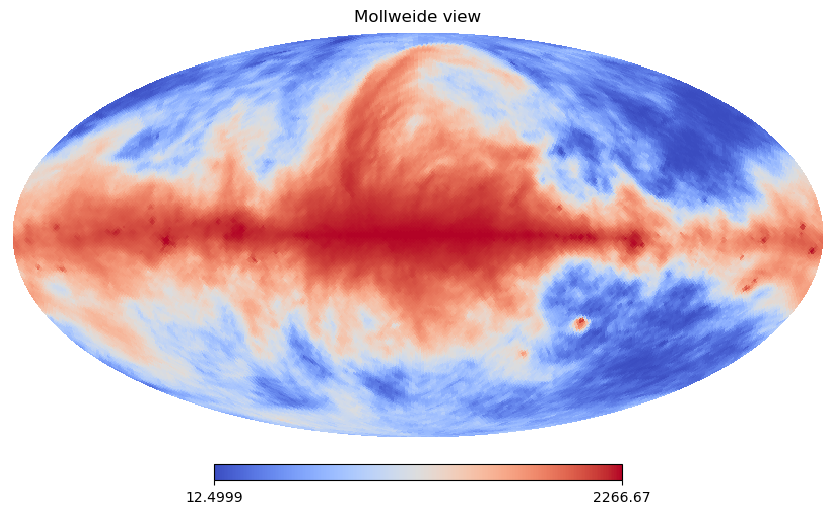

In [15]:
from astropy.io import fits

fits_image_filename = '../../SyncEmiss/obs/haslam408_dsds_Remazeilles2014.fits'

data = hp.read_map(fits_image_filename)

data = hp.reorder(data,r2n=True)

data = data.reshape((-1,64)).mean(axis=-1)

data = hp.reorder(data,n2r=True)

hp.mollview(data,norm='hist',cmap='coolwarm')
print(data.shape)

In [3]:
#for debug
def reload_package(package):
    importlib.reload(package)
    for attribute_name in dir(package):
        attribute = getattr(package, attribute_name)
        if type(attribute) == type(package):
            importlib.reload(attribute)
            
reload_package(synax)

## Set up coordinates and fields

During inference, there're some constant values such as the coordinates, $n_e$ fields and $C$ fields. We can pre calculate them to save some time during inference.

First let's generate the coordinates.

(3, 49152, 512)

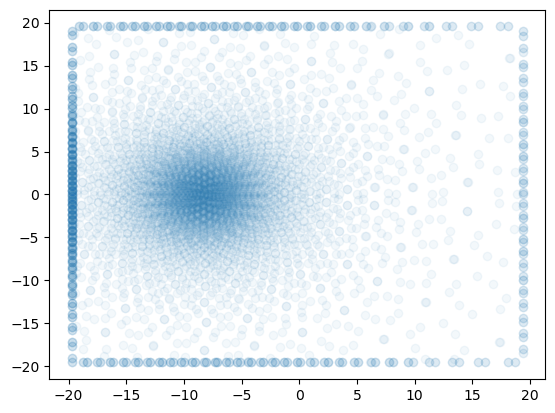

In [4]:
nside = 64
num_int_points = 512

poss,dls,nhats = synax.coords.get_healpix_positions(nside=nside,num_int_points=num_int_points)
plt.scatter(poss[0,::10,500],poss[1,::10,500],alpha=0.05)
poss.shape

Then generate C field

In [5]:
C_generator = synax.cfield.C_WMAP(poss)

C_field = C_generator.C_field()

Then grid $n_e$ field, read the grids in and construct generator, then interpolate.

In [6]:
nx,ny,nz = 256,256,64

xs,step = jnp.linspace(-20,20,nx,endpoint=False,retstep=True)
xs = xs + step*0.5

ys,step = jnp.linspace(-20,20,ny,endpoint=False,retstep=True)
ys = ys + step*0.5

zs,step = jnp.linspace(-5,5,nz,endpoint=False,retstep=True)
zs = zs + step*0.5

coords = jnp.meshgrid(xs,ys,zs,indexing='ij')
coords[0].shape

(256, 256, 64)

In [7]:

tereg = np.load('te.npy')# read it in.

In [8]:
TE_generator = synax.tefield.TE_grid(poss,(xs,ys,zs))# set up generator
TE_field = TE_generator.TE_field(tereg)# do interpolation

## Carry out optimization

Now let's optimize. The B field generator is also not a variable during inference, we can define one in advance.

First we need to set up coordinate system for this grid $\mathbf{B}$ field.

Then call `synax` to get the `B_generator`

In [9]:
nx,ny,nz = 128,128,32

xs,step = jnp.linspace(-20,20,nx,endpoint=False,retstep=True)
xs = xs + step*0.5

ys,step = jnp.linspace(-20,20,ny,endpoint=False,retstep=True)
ys = ys + step*0.5

zs,step = jnp.linspace(-5,5,nz,endpoint=False,retstep=True)
zs = zs + step*0.5

coords = jnp.meshgrid(xs,ys,zs,indexing='ij')
coords[0].shape

B_generator = synax.bfield.B_grid(poss,(xs,ys,zs))
B_field = jnp.ones((nx,ny,nz,3))*1e-6
B_generator.B_field(B_field).shape

(49152, 512, 3)

set up some constants, including frequency, simer and spectral index.

In [10]:
from datetime import date
rng_key = jax.random.key(42)
simer = synax.synax.Synax(sim_I = True,sim_P=False)
freq = 0.408
spectral_index = 3.

Here our loss function is simply MSE.

In [11]:
@jax.jit
def grid_model(B_field_grid,freq):
    # this function generates the sync I map with a grid B field
    B_field = B_generator.B_field(B_field_grid)
    
    sync = simer.sim(freq,B_field,C_field,TE_field,nhats,dls,spectral_index)
    
    return sync['I']


def logdensity_fn(B_field):
    # this function calculates the loss function with a grid B field
    Sync_I = grid_model(B_field,freq)

    return -1*jnp.sum(((Sync_I-data))**2)


B_field = (np.random.randn(nx,ny,nz,3)*1e-6)*jnp.array([1.,1.,0.1])
Sync_I = grid_model(B_field,freq)

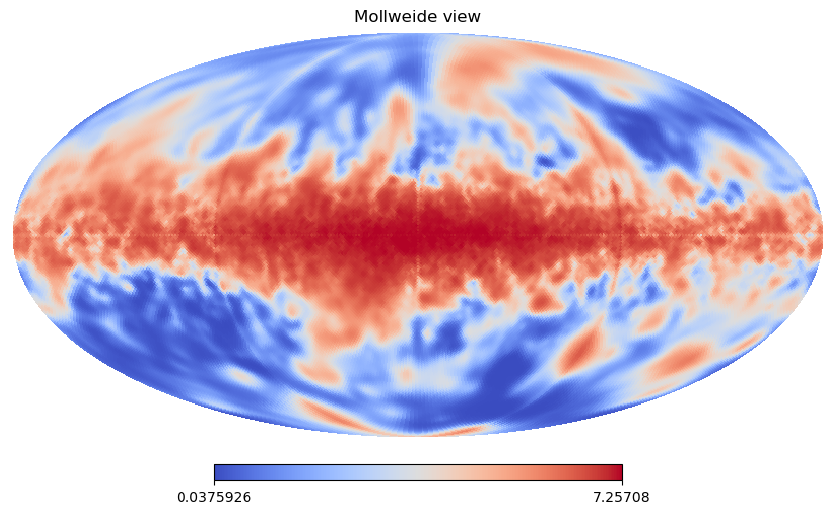

In [12]:
hp.mollview(Sync_I,norm='hist',cmap='coolwarm')

In [13]:
logp_grad = jax.value_and_grad(lambda x:-1*logdensity_fn(x))

Now let's optimize! here we use `optax` optimizer.

In [20]:
import optax
from tqdm import tqdm

B_field = (np.random.randn(*(nx,ny,nz,3))*1e-6)*jnp.array([1.,1.,0.1])

B_opt = B_field

solver = optax.yogi(learning_rate=1e-6)

opt_state = solver.init(B_opt)# initialize optimizer

loss = []

#create a mask
ones_field = np.ones((nx,ny,nz))

mask = ((coords[0]**2+coords[1]**2)>400)|((coords[0]**2+coords[1]**2)<9)# add a mask to mask inner region and outer region

ones_field[mask] = 1e-10 # can't be 0, 0 would cause polarization angle NaN problem.

mask = jnp.array(ones_field)[:,:,:,jnp.newaxis]

B_opt = B_opt*mask

progress_bar = tqdm(range(200))
for i in progress_bar:
    value,grad = logp_grad(B_opt)
    if jnp.isnan(value):
        break
    loss.append(value)
    updates, opt_state = solver.update(grad, opt_state, B_opt)
    B_opt = optax.apply_updates(B_opt, updates)
    B_opt = B_opt*mask
   
    info = { 'loss': loss[-1]}
    
    # Update the postfix with the current info
    progress_bar.set_postfix(info)

100%|██████████| 200/200 [01:11<00:00,  2.79it/s, loss=4319.830813641992] 


## visualize the results

First let's take a look at the 3 component of the B field at z = 0 kpc.

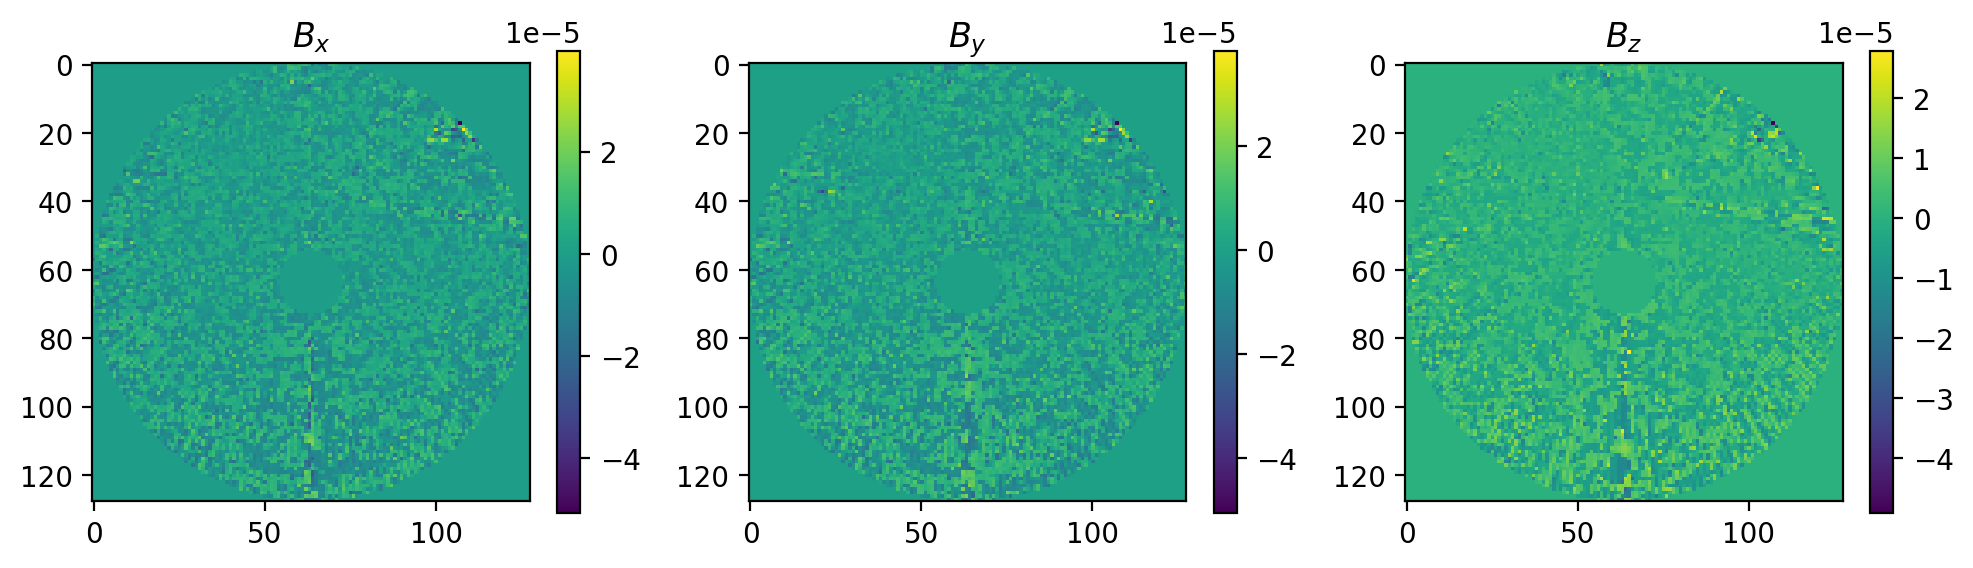

In [21]:
plt.figure(dpi=200,figsize=(12,3))

plt.subplot(131)
plt.imshow(B_opt[:,:,16,0])
plt.title(r'$B_x$')
plt.colorbar()

plt.subplot(132)
plt.imshow(B_opt[:,:,16,1])
plt.title(r'$B_y$')
plt.colorbar()

plt.subplot(133)
plt.imshow(B_opt[:,:,16,2])
plt.title(r'$B_z$')
plt.colorbar()

Re-simulate with this optimized $\mathcal{B}$ field.

In [22]:
Sync_I = grid_model(B_opt,freq)

Looks pretty! We did reproduce the Haslam map. However, the degree of freedom is too large to be constrained by a single map. Thus, this optimized B field is not really close to the truth.

But with more constraints we can get a better B field in the future.

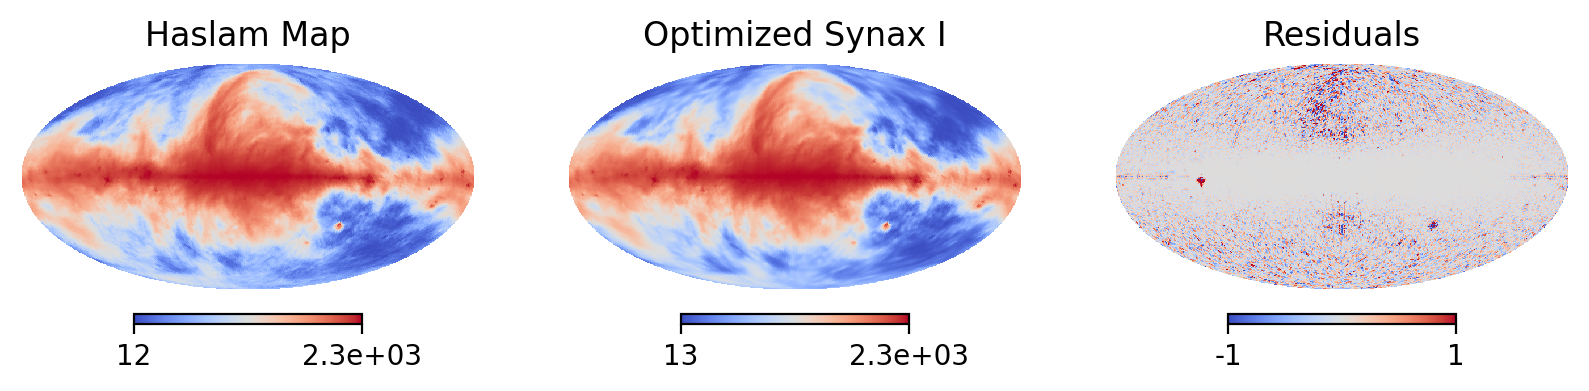

In [23]:
plt.figure(dpi=200,figsize=(10,3),)
np.random.seed(42)
plt.subplot(131)
hp.mollview(data,format='%.2g',norm='hist',cmap='coolwarm',hold=True,title='Haslam Map')

plt.subplot(132)
hp.mollview(Sync_I,format='%.2g',norm='hist',cmap='coolwarm',hold=True,title='Optimized Synax I')

plt.subplot(133)
hp.mollview(Sync_I-data,format='%.2g',cmap='coolwarm',hold=True,title='Residuals',max=1,min=-1)


#plt.savefig("../figures/haslam_opt.pdf",bbox_inches='tight',dpi=200)

Let's see the optimized B magnitude. Seems too high, ~10 times of the current estimation.

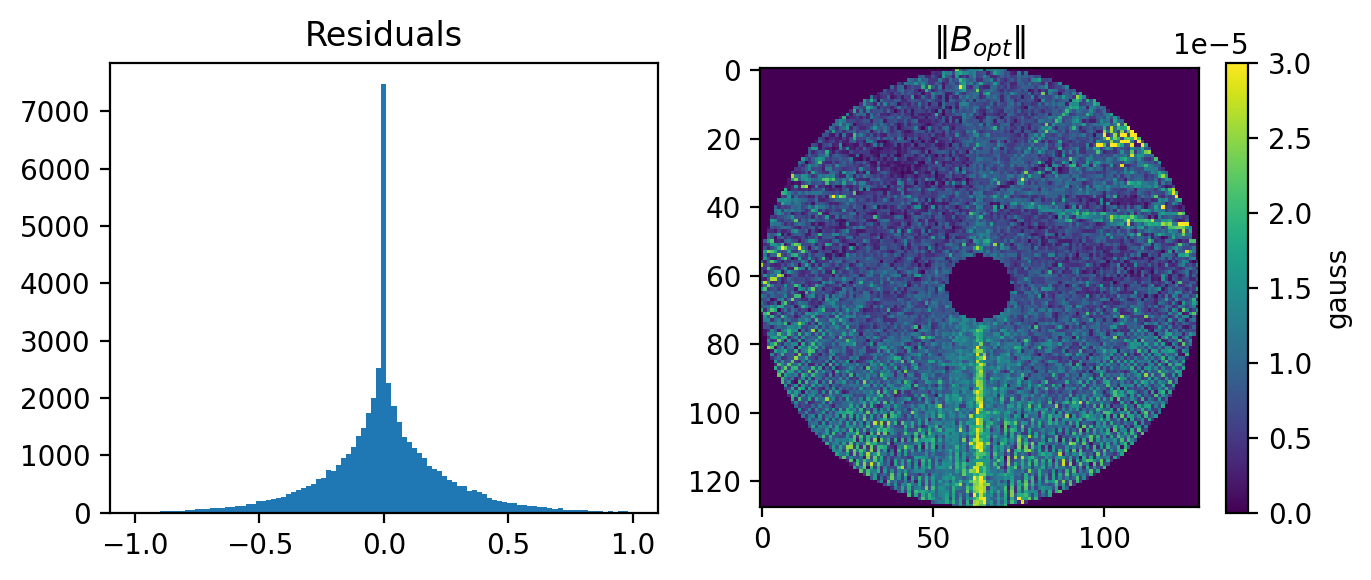

In [26]:
plt.figure(dpi=200,figsize=(7,3),)

plt.subplot(122)
plt.imshow(((B_opt**2).sum(axis=-1)**(1/2))[:,:,16],vmax=3e-5, vmin=0)
plt.colorbar(label='gauss')
plt.title(r'$\Vert B_{opt} \Vert$')

plt.subplot(121)
plt.hist(Sync_I-data,bins=np.linspace(-1,1,100))
plt.title('Residuals')
plt.tight_layout()
#plt.savefig("../figures/haslam_B.pdf",bbox_inches='tight',dpi=200)

In [25]:
np.std(Sync_I-data)

Array(0.29502564, dtype=float64)